# Gradient Flow Analysis for SA-V Fine-tuning

This notebook parses gradient snapshots saved during SA-V fine-tuning and builds summaries, diagnostics, and visualisations to inspect gradient flow stability. Adjust the experiment directory below if you want to inspect a different run under `projects/sav_finetune/exps/`.

## 1. Environment setup

Run the cell below to import the required libraries and choose the experiment you want to analyse.

In [1]:

%matplotlib inline

from pathlib import Path
import json
import re
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    plt.style.use('seaborn-darkgrid')

if hasattr(sns, 'set_theme'):
    sns.set_theme(style='darkgrid', context='notebook')
else:
    sns.set_style('darkgrid')

pd.set_option('display.float_format', lambda x: f"{x:,.6f}")

EPS = 1e-12


In [2]:
model = "tiny"
# Update these paths if you want to analyse a different fine-tuning run.
EXPERIMENT_DIR = Path(f'exps/{model}')
GRADIENT_DIR = EXPERIMENT_DIR / 'logs' / 'gradients'
STEP_WEIGHTS_DIR = EXPERIMENT_DIR / 'checkpoints' / 'step_weights'
DEFAULT_CHECKPOINT_PATH = EXPERIMENT_DIR / 'checkpoints' / 'checkpoint.pt'
TRAIN_STATS_PATH = EXPERIMENT_DIR / 'logs' / 'train_stats.json'

assert GRADIENT_DIR.exists(), f"Gradient directory not found: {GRADIENT_DIR}"
json_paths = sorted(GRADIENT_DIR.glob('gradients_step_*.json'))
STEP_WEIGHT_PATHS = sorted(STEP_WEIGHTS_DIR.glob('weights_step_*.pt')) if STEP_WEIGHTS_DIR.exists() else []

print(f'Found {len(json_paths)} gradient snapshots in {GRADIENT_DIR}')
if not json_paths:
    raise FileNotFoundError('No gradient JSON snapshots detected; check the experiment path.')

if STEP_WEIGHT_PATHS:
    print(f'Found {len(STEP_WEIGHT_PATHS)} per-step weight snapshots in {STEP_WEIGHTS_DIR}')
else:
    print(f'No per-step weight snapshots detected; falling back to {DEFAULT_CHECKPOINT_PATH} if available.')


Found 184 gradient snapshots in exps/tiny/logs/gradients
Found 184 per-step weight snapshots in exps/tiny/checkpoints/step_weights


## 2. Load gradient statistics and enrich features

The helper below reads every JSON snapshot, flattens per-parameter statistics into a DataFrame, and derives additional diagnostics such as RMS estimates, heavy-tail indicators, and sparsity proxies.

In [3]:

def remove_prefix(text: str, prefix: str) -> str:
    if text.startswith(prefix):
        return text[len(prefix):]
    return text


def collapse_name(name: str, depth: int = 4) -> str:
    '''Collapse a dotted parameter name to the requested depth.'''
    parts = name.split('.')
    if len(parts) <= depth:
        return '.'.join(parts)
    return '.'.join(parts[:depth])


def load_gradient_records(paths):
    records = []
    for path in paths:
        with path.open() as fp:
            payload = json.load(fp)
        step = payload.get('step')
        timestamp = payload.get('timestamp')
        log_every = payload.get('log_every')

        for parameter_name, info in payload.get('gradients', {}).items():
            stats = info.get('stats') or {}
            base_name = remove_prefix(parameter_name, 'module.')
            record = {
                'step': step,
                'timestamp': timestamp,
                'log_every': log_every,
                'parameter': parameter_name,
                'parameter_base': base_name,
                'module_group': collapse_name(base_name, depth=4),
                'has_grad': info.get('has_grad', False),
                'dtype': info.get('dtype'),
                'numel': info.get('numel'),
                'l2_norm': stats.get('l2_norm'),
                'mean': stats.get('mean'),
                'std': stats.get('std'),
                'max': stats.get('max'),
                'min': stats.get('min'),
            }
            records.append(record)

    df = pd.DataFrame.from_records(records)
    if df.empty:
        raise ValueError('Loaded gradient DataFrame is empty; check the input files.')

    numeric_cols = ['step', 'log_every', 'numel', 'l2_norm', 'mean', 'std', 'max', 'min']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.sort_values(['step', 'parameter'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    df['abs_mean'] = df['mean'].abs()
    df['max_abs'] = np.maximum(df['max'].abs(), df['min'].abs())
    df['rms'] = df['l2_norm'] / np.sqrt(df['numel'].clip(lower=1))
    df['max_to_mean_ratio'] = df['max_abs'] / df['abs_mean'].clip(lower=EPS)
    df['effective_support'] = np.clip((df['l2_norm'] / df['max_abs'].clip(lower=EPS)) ** 2, 0, df['numel'])
    df['sparsity_proxy'] = 1 - (df['effective_support'] / df['numel'].clip(lower=1))
    df['std_over_mean'] = df['std'] / df['abs_mean'].clip(lower=EPS)
    df['log_l2_norm'] = np.log10(df['l2_norm'].clip(lower=EPS))

    return df


gradient_df = load_gradient_records(json_paths)
print(f'Loaded {len(gradient_df)} per-parameter records across {gradient_df.step.nunique()} steps.')
gradient_df.head()


Loaded 86480 per-parameter records across 184 steps.


,step,timestamp,log_every,parameter,parameter_base,module_group,has_grad,dtype,numel,l2_norm,...,max,min,abs_mean,max_abs,rms,max_to_mean_ratio,effective_support,sparsity_proxy,std_over_mean,log_l2_norm
0,100,2025-11-10 13:29:57.795739+00:00,100,module.image_encoder.neck.convs.0.conv.bias,image_encoder.neck.convs.0.conv.bias,image_encoder.neck.convs.0,True,float32,256.000000,0.001032,...,0.000147,-0.000188,0.000001,0.000188,0.000065,270.904457,30.140906,0.882262,92.949956,-2.986303
1,100,2025-11-10 13:29:57.795739+00:00,100,module.image_encoder.neck.convs.0.conv.weight,image_encoder.neck.convs.0.conv.weight,image_encoder.neck.convs.0,True,float32,"196,608.000000",0.002786,...,0.000104,-0.000135,0.000000,0.000135,0.000006,"40,582.482142",426.929565,0.997829,"1,891.108866",-2.554983
2,100,2025-11-10 13:29:57.795739+00:00,100,module.image_encoder.neck.convs.1.conv.bias,image_encoder.neck.convs.1.conv.bias,image_encoder.neck.convs.1,True,float32,256.000000,0.001032,...,0.000147,-0.000188,0.000001,0.000188,0.000065,268.609542,30.148091,0.882234,92.173450,-2.986241
3,100,2025-11-10 13:29:57.795739+00:00,100,module.image_encoder.neck.convs.1.conv.weight,image_encoder.neck.convs.1.conv.weight,image_encoder.neck.convs.1,True,float32,"98,304.000000",0.006655,...,0.000422,-0.000472,0.000000,0.000472,0.000021,"15,852.494572",198.894390,0.997977,713.055201,-2.176883
4,100,2025-11-10 13:29:57.795739+00:00,100,module.image_encoder.neck.convs.2.conv.bias,image_encoder.neck.convs.2.conv.bias,image_encoder.neck.convs.2,True,float32,256.000000,0.000101,...,0.000021,-0.000018,0.000000,0.000021,0.000006,112.651102,23.946090,0.906461,34.438937,-3.995167


## 3. Load weight statistics (for grad/weight ratio)

This notebook now prefers per-step checkpoints saved under `step_weights` so each gradient snapshot is paired with the corresponding weights. If those snapshots are missing, it falls back to `DEFAULT_CHECKPOINT_PATH` just like before.


In [4]:

def resolve_state_dict(payload):
    if isinstance(payload, dict):
        for key in ('model', 'state_dict', 'model_state_dict'):
            candidate = payload.get(key)
            if isinstance(candidate, dict):
                return candidate
        return payload
    return payload


STEP_PATTERN = re.compile(r'(\d+)(?=\.pt$)')


def parse_step_from_path(path: Path) -> int | None:
    match = STEP_PATTERN.search(path.name)
    if match:
        return int(match.group(1))
    return None


def summarise_state_dict(state_dict, *, step: int | None):
    records = []
    for name, tensor in state_dict.items():
        if not torch.is_tensor(tensor) or not tensor.is_floating_point():
            continue
        arr = tensor.detach().float()
        numel = int(arr.numel())
        if numel == 0:
            continue
        base_name = remove_prefix(name, 'module.')
        std = arr.std(unbiased=False).item() if numel > 1 else 0.0
        records.append({
            'step': step,
            'parameter_base': base_name,
            'weight_numel': numel,
            'weight_l2_norm': arr.norm().item(),
            'weight_mean': arr.mean().item(),
            'weight_std': std,
            'weight_max_abs': arr.abs().max().item(),
        })
    return records


def load_weight_snapshots(step_paths, steps_to_use):
    if not step_paths:
        return None, []

    step_lookup = {}
    for path in step_paths:
        step_val = parse_step_from_path(path)
        if step_val is not None:
            step_lookup[step_val] = path

    valid_steps = sorted({int(s) for s in steps_to_use if pd.notna(s)})
    records = []
    missing = []
    for step in valid_steps:
        ckpt_path = step_lookup.get(step)
        if ckpt_path is None:
            missing.append(step)
            continue
        ckpt = torch.load(ckpt_path, map_location='cpu')
        state_dict = resolve_state_dict(ckpt)
        records.extend(summarise_state_dict(state_dict, step=step))

    if not records:
        return None, missing

    return pd.DataFrame.from_records(records), missing


def load_single_checkpoint(checkpoint_path: Path):
    if not checkpoint_path or not checkpoint_path.exists():
        return None

    ckpt = torch.load(checkpoint_path, map_location='cpu')
    state_dict = resolve_state_dict(ckpt)
    records = summarise_state_dict(state_dict, step=None)
    if not records:
        return None

    df = pd.DataFrame.from_records(records)
    return df.drop(columns=['step'])


weight_df, missing_steps = load_weight_snapshots(STEP_WEIGHT_PATHS, gradient_df['step'])
merge_keys = ['step', 'parameter_base']

if weight_df is None:
    weight_df = load_single_checkpoint(DEFAULT_CHECKPOINT_PATH)
    merge_keys = ['parameter_base']
    missing_steps = []

if weight_df is not None:
    alignment_label = 'per-step snapshots' if merge_keys == ['step', 'parameter_base'] else 'final checkpoint'
    gradient_df = gradient_df.merge(weight_df, on=merge_keys, how='left')
    gradient_df['weight_l2_norm'] = gradient_df['weight_l2_norm'].clip(lower=EPS)
    if 'weight_max_abs' in gradient_df:
        gradient_df['weight_max_abs'] = gradient_df['weight_max_abs'].clip(lower=EPS)
    else:
        gradient_df['weight_max_abs'] = np.nan
    gradient_df['grad_weight_ratio'] = gradient_df['l2_norm'] / gradient_df['weight_l2_norm']
    if 'weight_numel' in gradient_df:
        denominator = np.sqrt(gradient_df['weight_numel'].clip(lower=1))
        gradient_df['weight_rms'] = gradient_df['weight_l2_norm'] / denominator
        gradient_df['grad_weight_rms_ratio'] = gradient_df['rms'] / gradient_df['weight_rms'].clip(lower=EPS)
    else:
        gradient_df['weight_rms'] = np.nan
        gradient_df['grad_weight_rms_ratio'] = np.nan
    param_count = weight_df['parameter_base'].nunique()
    step_count = weight_df['step'].nunique() if 'step' in weight_df.columns else 1
    print(
        f'Back-filled weight statistics for {param_count} parameters using {alignment_label} ({step_count} snapshot(s)).'
    )
    if missing_steps:
        preview = ', '.join(map(str, missing_steps[:8]))
        suffix = '...' if len(missing_steps) > 8 else ''
        print(f'Warning: missing weight snapshots for {len(missing_steps)} steps: {preview}{suffix}')
else:
    gradient_df['grad_weight_ratio'] = np.nan
    gradient_df['grad_weight_rms_ratio'] = np.nan
    gradient_df['weight_rms'] = np.nan
    print('Could not locate any weight snapshots; grad/weight ratios will be NaN.')

gradient_df.head()


Back-filled weight statistics for 471 parameters using per-step snapshots (184 snapshot(s)).


,step,timestamp,log_every,parameter,parameter_base,module_group,has_grad,dtype,numel,l2_norm,...,std_over_mean,log_l2_norm,weight_numel,weight_l2_norm,weight_mean,weight_std,weight_max_abs,grad_weight_ratio,weight_rms,grad_weight_rms_ratio
0,100,2025-11-10 13:29:57.795739+00:00,100,module.image_encoder.neck.convs.0.conv.bias,image_encoder.neck.convs.0.conv.bias,image_encoder.neck.convs.0,True,float32,256.000000,0.001032,...,92.949956,-2.986303,256,1.113998,0.006934,0.069279,0.586324,0.000926,0.069625,0.000926
1,100,2025-11-10 13:29:57.795739+00:00,100,module.image_encoder.neck.convs.0.conv.weight,image_encoder.neck.convs.0.conv.weight,image_encoder.neck.convs.0,True,float32,"196,608.000000",0.002786,...,"1,891.108866",-2.554983,196608,6.145648,0.000007,0.013860,0.088535,0.000453,0.013860,0.000453
2,100,2025-11-10 13:29:57.795739+00:00,100,module.image_encoder.neck.convs.1.conv.bias,image_encoder.neck.convs.1.conv.bias,image_encoder.neck.convs.1,True,float32,256.000000,0.001032,...,92.173450,-2.986241,256,1.139868,0.003091,0.071175,0.580515,0.000906,0.071242,0.000906
3,100,2025-11-10 13:29:57.795739+00:00,100,module.image_encoder.neck.convs.1.conv.weight,image_encoder.neck.convs.1.conv.weight,image_encoder.neck.convs.1,True,float32,"98,304.000000",0.006655,...,713.055201,-2.176883,98304,6.299991,0.000049,0.020093,0.160527,0.001056,0.020093,0.001056
4,100,2025-11-10 13:29:57.795739+00:00,100,module.image_encoder.neck.convs.2.conv.bias,image_encoder.neck.convs.2.conv.bias,image_encoder.neck.convs.2,True,float32,256.000000,0.000101,...,34.438937,-3.995167,256,0.687733,-0.002823,0.042891,0.136714,0.000147,0.042983,0.000147


## 4. Run-level summary

Aggregate statistics reveal how many parameters were tracked, how frequently gradients were logged, and basic magnitude ranges.

In [5]:

summary = pd.Series({
    'steps_tracked': gradient_df.step.nunique(),
    'snapshot_interval': gradient_df['log_every'].dropna().iloc[0],
    'parameters_logged': gradient_df.parameter.nunique(),
    'parameters_with_gradients': int(gradient_df[gradient_df.has_grad].parameter.nunique()),
    'min_total_l2': gradient_df.groupby('step')['l2_norm'].sum().min(),
    'max_total_l2': gradient_df.groupby('step')['l2_norm'].sum().max(),
    'mean_total_l2': gradient_df.groupby('step')['l2_norm'].sum().mean(),
})
summary.to_frame(name='value')


,value
steps_tracked,184.000000
snapshot_interval,100.000000
parameters_logged,470.000000
parameters_with_gradients,469.000000
min_total_l2,0.342490
max_total_l2,0.957805
mean_total_l2,0.661256


## 5. Gradient flow over time

Overall gradient magnitude trends across training steps. Large spikes or vanishing norms are easy to spot here.

In [6]:

per_step = gradient_df.groupby('step').agg(
    total_l2_norm=('l2_norm', 'sum'),
    mean_l2_norm=('l2_norm', 'mean'),
    median_l2_norm=('l2_norm', 'median'),
    active_parameters=('has_grad', 'sum'),
    ratio_mean=('grad_weight_ratio', 'mean'),
    ratio_rms_mean=('grad_weight_rms_ratio', 'mean'),
)
display(per_step)
per_step.to_csv(f'{model}/per_step.csv')


,total_l2_norm,mean_l2_norm,median_l2_norm,active_parameters,ratio_mean,ratio_rms_mean
step,,,,,,
100,0.628415,0.001343,0.000337,468,0.000670,0.000670
200,0.710344,0.001518,0.000364,468,0.000655,0.000655
300,0.666396,0.001424,0.000309,468,0.000627,0.000627
400,0.722582,0.001547,0.000363,467,0.001161,0.001161
500,0.676449,0.001448,0.000347,467,0.000965,0.000965
...,...,...,...,...,...,...
18000,0.633518,0.001354,0.000284,468,0.000520,0.000520
18100,0.716891,0.001535,0.000220,467,0.000815,0.000815
18200,0.508185,0.001086,0.000231,468,0.000490,0.000490


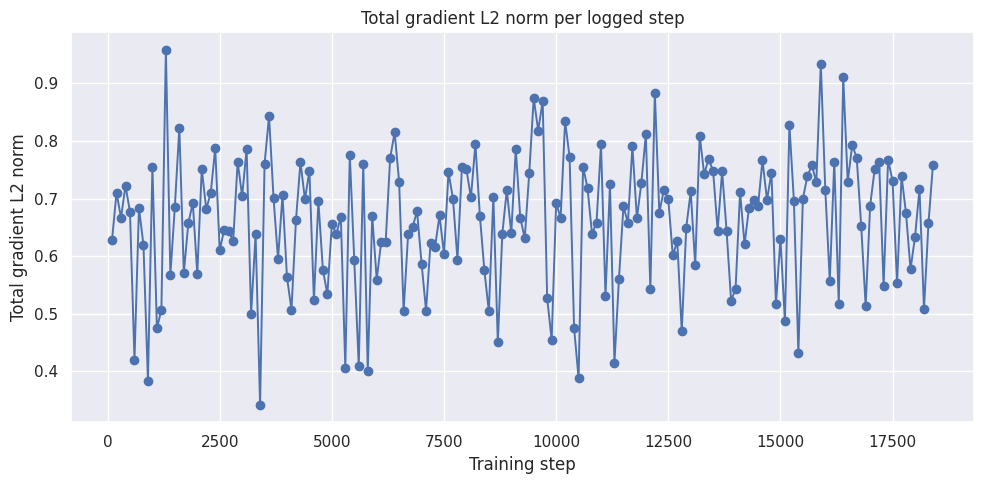

In [7]:

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(per_step.index, per_step['total_l2_norm'], marker='o', linewidth=1.4)
ax.set_xlabel('Training step')
ax.set_ylabel('Total gradient L2 norm')
ax.set_title('Total gradient L2 norm per logged step')
plt.tight_layout()
plt.show()


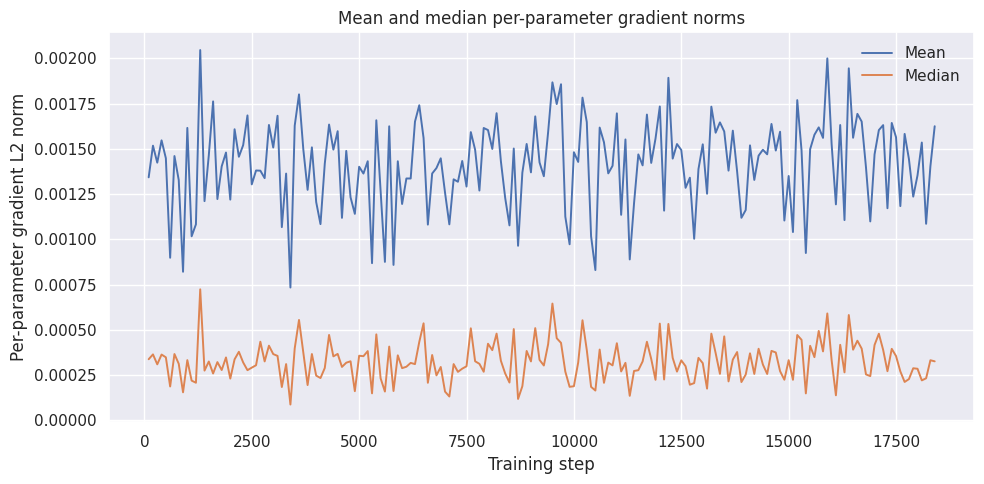

In [8]:

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(per_step.index, per_step['mean_l2_norm'], label='Mean', linewidth=1.4)
ax.plot(per_step.index, per_step['median_l2_norm'], label='Median', linewidth=1.4)
ax.set_xlabel('Training step')
ax.set_ylabel('Per-parameter gradient L2 norm')
ax.set_title('Mean and median per-parameter gradient norms')
ax.legend()
plt.tight_layout()
plt.show()


## 6. Parameter-level views

Identify the dominant parameters and visualise their trajectories across training.

In [9]:

top_parameters = (
    gradient_df[gradient_df.has_grad]
    .groupby('parameter')['l2_norm']
    .mean()
    .sort_values(ascending=False)
)

print('Top parameters by average L2 norm:')
top_parameters.head(15).to_frame('mean_l2_norm')


Top parameters by average L2 norm:


,mean_l2_norm
parameter,
module.image_encoder.trunk.patch_embed.proj.weight,0.078759
module.image_encoder.trunk.blocks.0.mlp.layers.1.weight,0.020777
module.image_encoder.trunk.blocks.1.proj.weight,0.018387
module.image_encoder.trunk.blocks.3.proj.weight,0.016504
module.memory_encoder.mask_downsampler.encoder.0.weight,0.012356
module.image_encoder.trunk.blocks.0.mlp.layers.0.weight,0.009320
module.memory_encoder.mask_downsampler.encoder.3.bias,0.008696
module.image_encoder.trunk.blocks.1.mlp.layers.1.weight,0.008114
module.image_encoder.trunk.blocks.3.mlp.layers.1.weight,0.008102


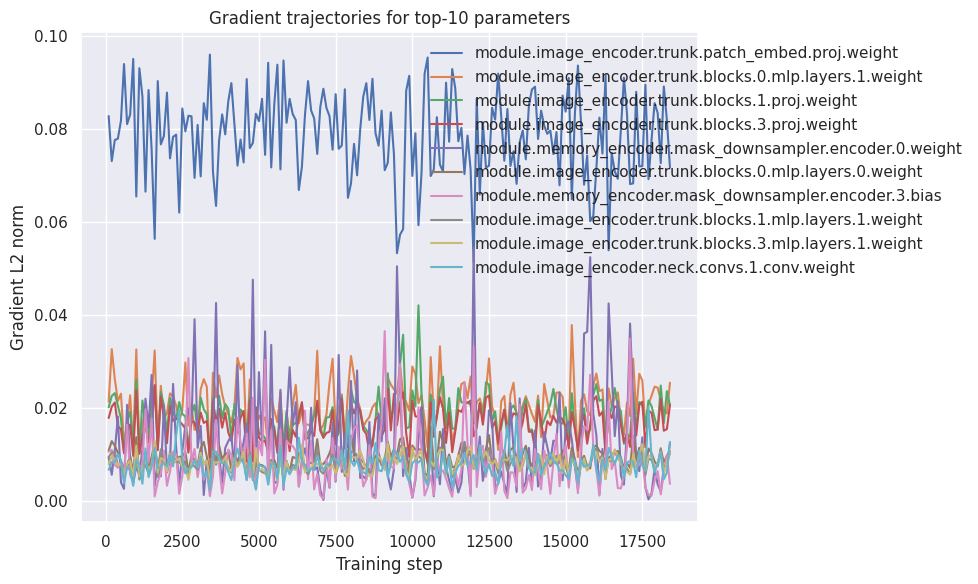

In [10]:

fig, ax = plt.subplots(figsize=(11, 6))
for name in top_parameters.head(10).index:
    subset = gradient_df[gradient_df.parameter == name]
    ax.plot(subset['step'], subset['l2_norm'], label=name)

ax.set_xlabel('Training step')
ax.set_ylabel('Gradient L2 norm')
ax.set_title('Gradient trajectories for top-10 parameters')
ax.legend(loc='upper right', bbox_to_anchor=(1.45, 1))
plt.tight_layout()
plt.show()


## 7. Module-level rollups

Aggregate gradients at a coarser granularity to surface dominant submodules.

In [11]:

top_groups = (
    gradient_df[gradient_df.has_grad]
    .groupby('module_group')['l2_norm']
    .mean()
    .sort_values(ascending=False)
)

print('Top module groups by average gradient norm:')
top_groups.head(15).to_frame('mean_l2_norm')


Top module groups by average gradient norm:


,mean_l2_norm
module_group,
image_encoder.trunk.patch_embed.proj,0.041755
memory_encoder.mask_downsampler.encoder.0,0.006427
memory_encoder.mask_downsampler.encoder.3,0.005881
image_encoder.trunk.pos_embed_window,0.005586
sam_prompt_encoder.mask_downscaling.3.bias,0.005574
image_encoder.trunk.pos_embed,0.005253
image_encoder.neck.convs.1,0.004506
image_encoder.trunk.blocks.0,0.004218
sam_mask_decoder.output_upscaling.3.weight,0.004195


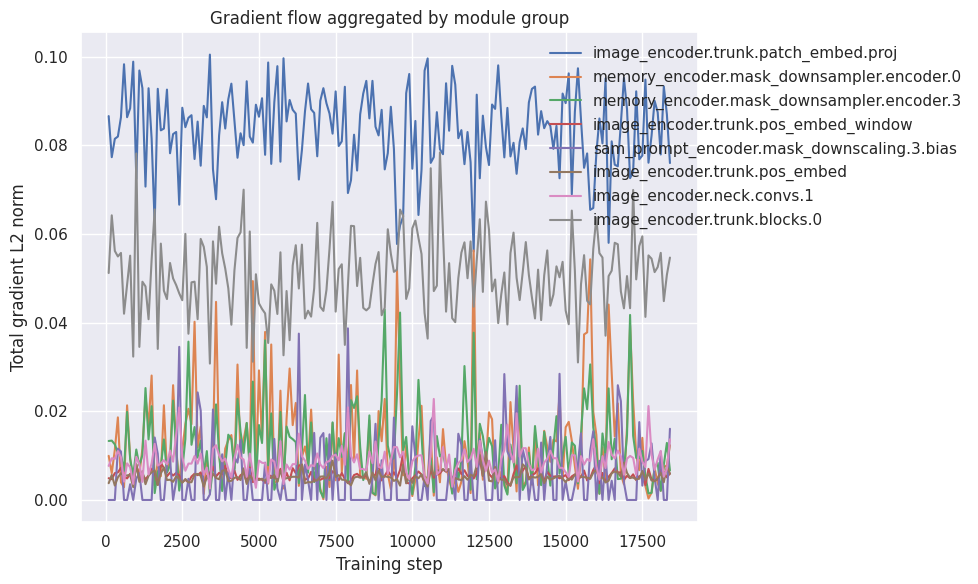

In [12]:

fig, ax = plt.subplots(figsize=(11, 6))
for group in top_groups.head(8).index:
    subset = gradient_df[gradient_df.module_group == group]
    series = subset.groupby('step')['l2_norm'].sum()
    ax.plot(series.index, series.values, label=group)

ax.set_xlabel('Training step')
ax.set_ylabel('Total gradient L2 norm')
ax.set_title('Gradient flow aggregated by module group')
ax.legend(loc='upper right', bbox_to_anchor=(1.45, 1))
plt.tight_layout()
plt.show()


## 8. Distribution views

Look at the spread of gradient magnitudes at any step to understand whether most parameters are quiet or if there are long tails.

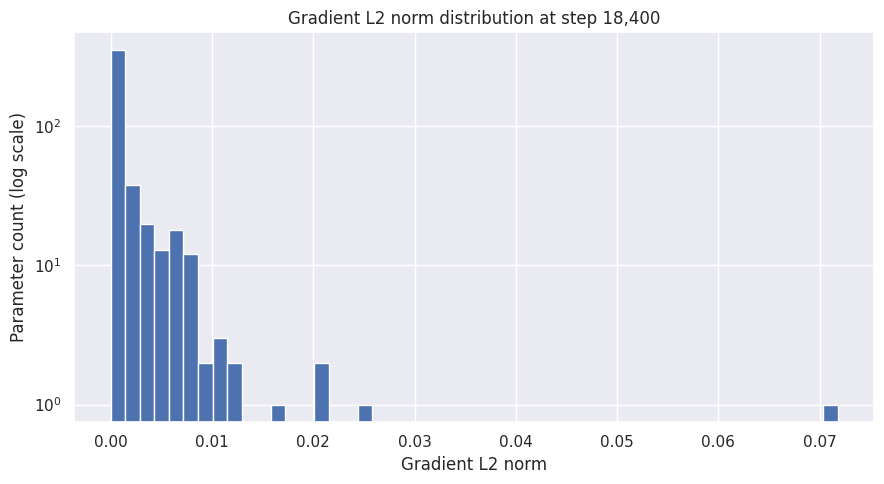

In [13]:

latest_step = gradient_df['step'].max()
latest_snapshot = gradient_df[gradient_df['step'] == latest_step]

fig, ax = plt.subplots(figsize=(9, 5))
ax.hist(latest_snapshot['l2_norm'].dropna(), bins=50, log=True)
ax.set_xlabel('Gradient L2 norm')
ax.set_ylabel('Parameter count (log scale)')
ax.set_title(f'Gradient L2 norm distribution at step {latest_step:,}')
plt.tight_layout()
plt.show()


,parameter,module_group,l2_norm,mean,std,has_grad
86169,module.image_encoder.trunk.patch_embed.proj.we...,image_encoder.trunk.patch_embed.proj,0.071778,0.000005,0.000604,True
86025,module.image_encoder.trunk.blocks.0.mlp.layers...,image_encoder.trunk.blocks.0,0.025425,-0.000001,0.000132,True
86043,module.image_encoder.trunk.blocks.1.proj.weight,image_encoder.trunk.blocks.1,0.020625,-0.000000,0.000152,True
86095,module.image_encoder.trunk.blocks.3.proj.weight,image_encoder.trunk.blocks.3,0.020614,0.000000,0.000076,True
86468,module.sam_prompt_encoder.mask_downscaling.3.bias,sam_prompt_encoder.mask_downscaling.3.bias,0.016062,-0.000002,0.004015,True
86013,module.image_encoder.neck.convs.1.conv.weight,image_encoder.neck.convs.1,0.012675,-0.000000,0.000040,True
86300,module.memory_encoder.mask_downsampler.encoder...,memory_encoder.mask_downsampler.encoder.0,0.012297,-0.000014,0.002050,True
86023,module.image_encoder.trunk.blocks.0.mlp.layers...,image_encoder.trunk.blocks.0,0.010624,-0.000000,0.000055,True
86089,module.image_encoder.trunk.blocks.3.mlp.layers...,image_encoder.trunk.blocks.3,0.010434,-0.000000,0.000014,True
86037,module.image_encoder.trunk.blocks.1.mlp.layers...,image_encoder.trunk.blocks.1,0.010252,0.000000,0.000027,True


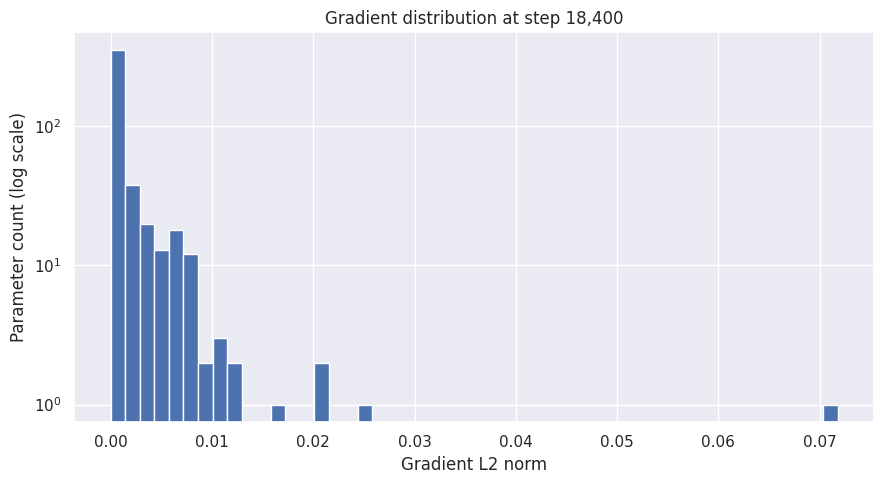

In [14]:

def inspect_step(step_value: int):
    '''Print summary stats and histogram for a specific logged step.'''
    subset = gradient_df[gradient_df['step'] == step_value]
    if subset.empty:
        raise ValueError(f'Step {step_value} not found in the logged snapshots.')
    display(subset[['parameter', 'module_group', 'l2_norm', 'mean', 'std', 'has_grad']].sort_values('l2_norm', ascending=False).head(20))
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.hist(subset['l2_norm'].dropna(), bins=50, log=True)
    ax.set_xlabel('Gradient L2 norm')
    ax.set_ylabel('Parameter count (log scale)')
    ax.set_title(f'Gradient distribution at step {step_value:,}')
    plt.tight_layout()
    plt.show()

inspect_step(latest_step)


## 9. Layer-level aggregation for advanced diagnostics

Roll gradients up per layer and compute moving averages, heavy-tail indicators, sparsity proxies, and grad/weight ratios.

In [15]:

module_step = (
    gradient_df[gradient_df.has_grad]
    .groupby(['step', 'module_group'])
    .agg(
        total_l2=('l2_norm', 'sum'),
        mean_l2=('l2_norm', 'mean'),
        median_l2=('l2_norm', 'median'),
        grad_weight_ratio_mean=('grad_weight_ratio', 'mean'),
        grad_weight_ratio_median=('grad_weight_ratio', 'median'),
        grad_weight_rms_ratio_mean=('grad_weight_rms_ratio', 'mean'),
        grad_weight_rms_ratio_median=('grad_weight_rms_ratio', 'median'),
        max_to_mean_avg=('max_to_mean_ratio', 'mean'),
        sparsity_avg=('sparsity_proxy', 'mean'),
        rms_mean=('rms', 'mean'),
        parameter_count=('parameter', 'nunique'),
    )
    .reset_index()
)

module_step.sort_values(['module_group', 'step'], inplace=True)

module_step['ma_total_l2'] = module_step.groupby('module_group')['total_l2'].transform(
    lambda s: s.rolling(window=10, min_periods=1).mean()
)
module_step['std_total_l2'] = module_step.groupby('module_group')['total_l2'].transform(
    lambda s: s.rolling(window=10, min_periods=1).std().fillna(0.0)
)
module_step['ma_ratio'] = module_step.groupby('module_group')['grad_weight_ratio_mean'].transform(
    lambda s: s.rolling(window=10, min_periods=1).mean()
)
module_step['std_ratio'] = module_step.groupby('module_group')['grad_weight_ratio_mean'].transform(
    lambda s: s.rolling(window=10, min_periods=1).std().fillna(0.0)
)

display(module_step.head())
module_step.to_csv(f'{model}/module_step.csv')


,step,module_group,total_l2,mean_l2,median_l2,grad_weight_ratio_mean,grad_weight_ratio_median,grad_weight_rms_ratio_mean,grad_weight_rms_ratio_median,max_to_mean_avg,sparsity_avg,rms_mean,parameter_count,ma_total_l2,std_total_l2,ma_ratio,std_ratio
0,100,image_encoder.neck.convs.0,0.003818,0.001909,0.001909,0.000690,0.000690,0.000690,0.000690,"20,426.693299",0.940045,0.000035,2,0.003818,0.000000,0.000690,0.000000
124,200,image_encoder.neck.convs.0,0.004273,0.002136,0.002136,0.000733,0.000733,0.000733,0.000733,"7,337.697226",0.945685,0.000036,2,0.004046,0.000321,0.000712,0.000031
248,300,image_encoder.neck.convs.0,0.004398,0.002199,0.002199,0.000710,0.000710,0.000710,0.000710,"6,951.960592",0.965128,0.000034,2,0.004163,0.000305,0.000711,0.000022
372,400,image_encoder.neck.convs.0,0.004312,0.002156,0.002156,0.000710,0.000710,0.000710,0.000710,"1,895.129017",0.951369,0.000034,2,0.004200,0.000260,0.000711,0.000018
495,500,image_encoder.neck.convs.0,0.004471,0.002236,0.002236,0.000677,0.000677,0.000677,0.000677,"1,517.072617",0.954399,0.000031,2,0.004254,0.000256,0.000704,0.000022


## 10. Grad/weight ratio diagnostics

Ratios ≳0.1 can indicate aggressive updates relative to parameter scale; track both rankings and time series.

In [16]:

ratio_summary = (
    module_step.groupby('module_group')[['grad_weight_ratio_mean', 'grad_weight_rms_ratio_mean']]
    .mean()
    .rename(columns={
        'grad_weight_ratio_mean': 'avg_grad_weight_ratio',
        'grad_weight_rms_ratio_mean': 'avg_grad_weight_rms_ratio',
    })
    .sort_values('avg_grad_weight_ratio', ascending=False)
)
ratio_summary.head(20)


,avg_grad_weight_ratio,avg_grad_weight_rms_ratio
module_group,,
sam_prompt_encoder.mask_downscaling.3.bias,0.057274,0.057274
memory_encoder.mask_downsampler.encoder.0,0.028175,0.028175
memory_encoder.mask_downsampler.encoder.3,0.026601,0.026601
image_encoder.trunk.patch_embed.proj,0.020656,0.020656
sam_prompt_encoder.mask_downscaling.0.weight,0.016957,0.016957
memory_encoder.mask_downsampler.encoder.6,0.010031,0.010031
sam_mask_decoder.conv_s0.bias,0.006627,0.006627
sam_mask_decoder.output_upscaling.3.bias,0.005496,0.005496
sam_prompt_encoder.mask_downscaling.3.weight,0.004678,0.004678


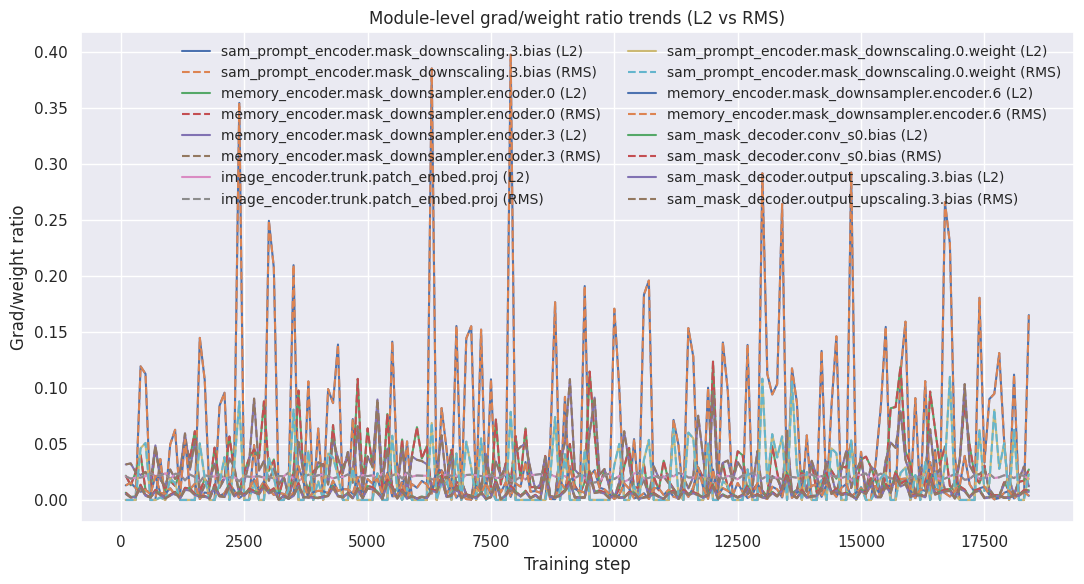

In [17]:

top_ratio_modules = ratio_summary.head(8).index
fig, ax = plt.subplots(figsize=(11, 6))
for module in top_ratio_modules:
    subset = module_step[module_step.module_group == module]
    ax.plot(subset['step'], subset['grad_weight_ratio_mean'], label=f"{module} (L2)")
    if 'grad_weight_rms_ratio_mean' in subset and subset['grad_weight_rms_ratio_mean'].notna().any():
        ax.plot(
            subset['step'],
            subset['grad_weight_rms_ratio_mean'],
            linestyle='--',
            label=f"{module} (RMS)",
        )

ax.set_xlabel('Training step')
ax.set_ylabel('Grad/weight ratio')
ax.set_title('Module-level grad/weight ratio trends (L2 vs RMS)')
ax.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()


## 11. Moving averages & stability bands

Overlay raw gradient energy, a moving average (window=10 steps), and ±1σ bands to distinguish stable and unstable layers.

/tmp/ipykernel_2232128/3925921942.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stability_score = module_step.groupby('module_group').apply(compute_stability).sort_values()


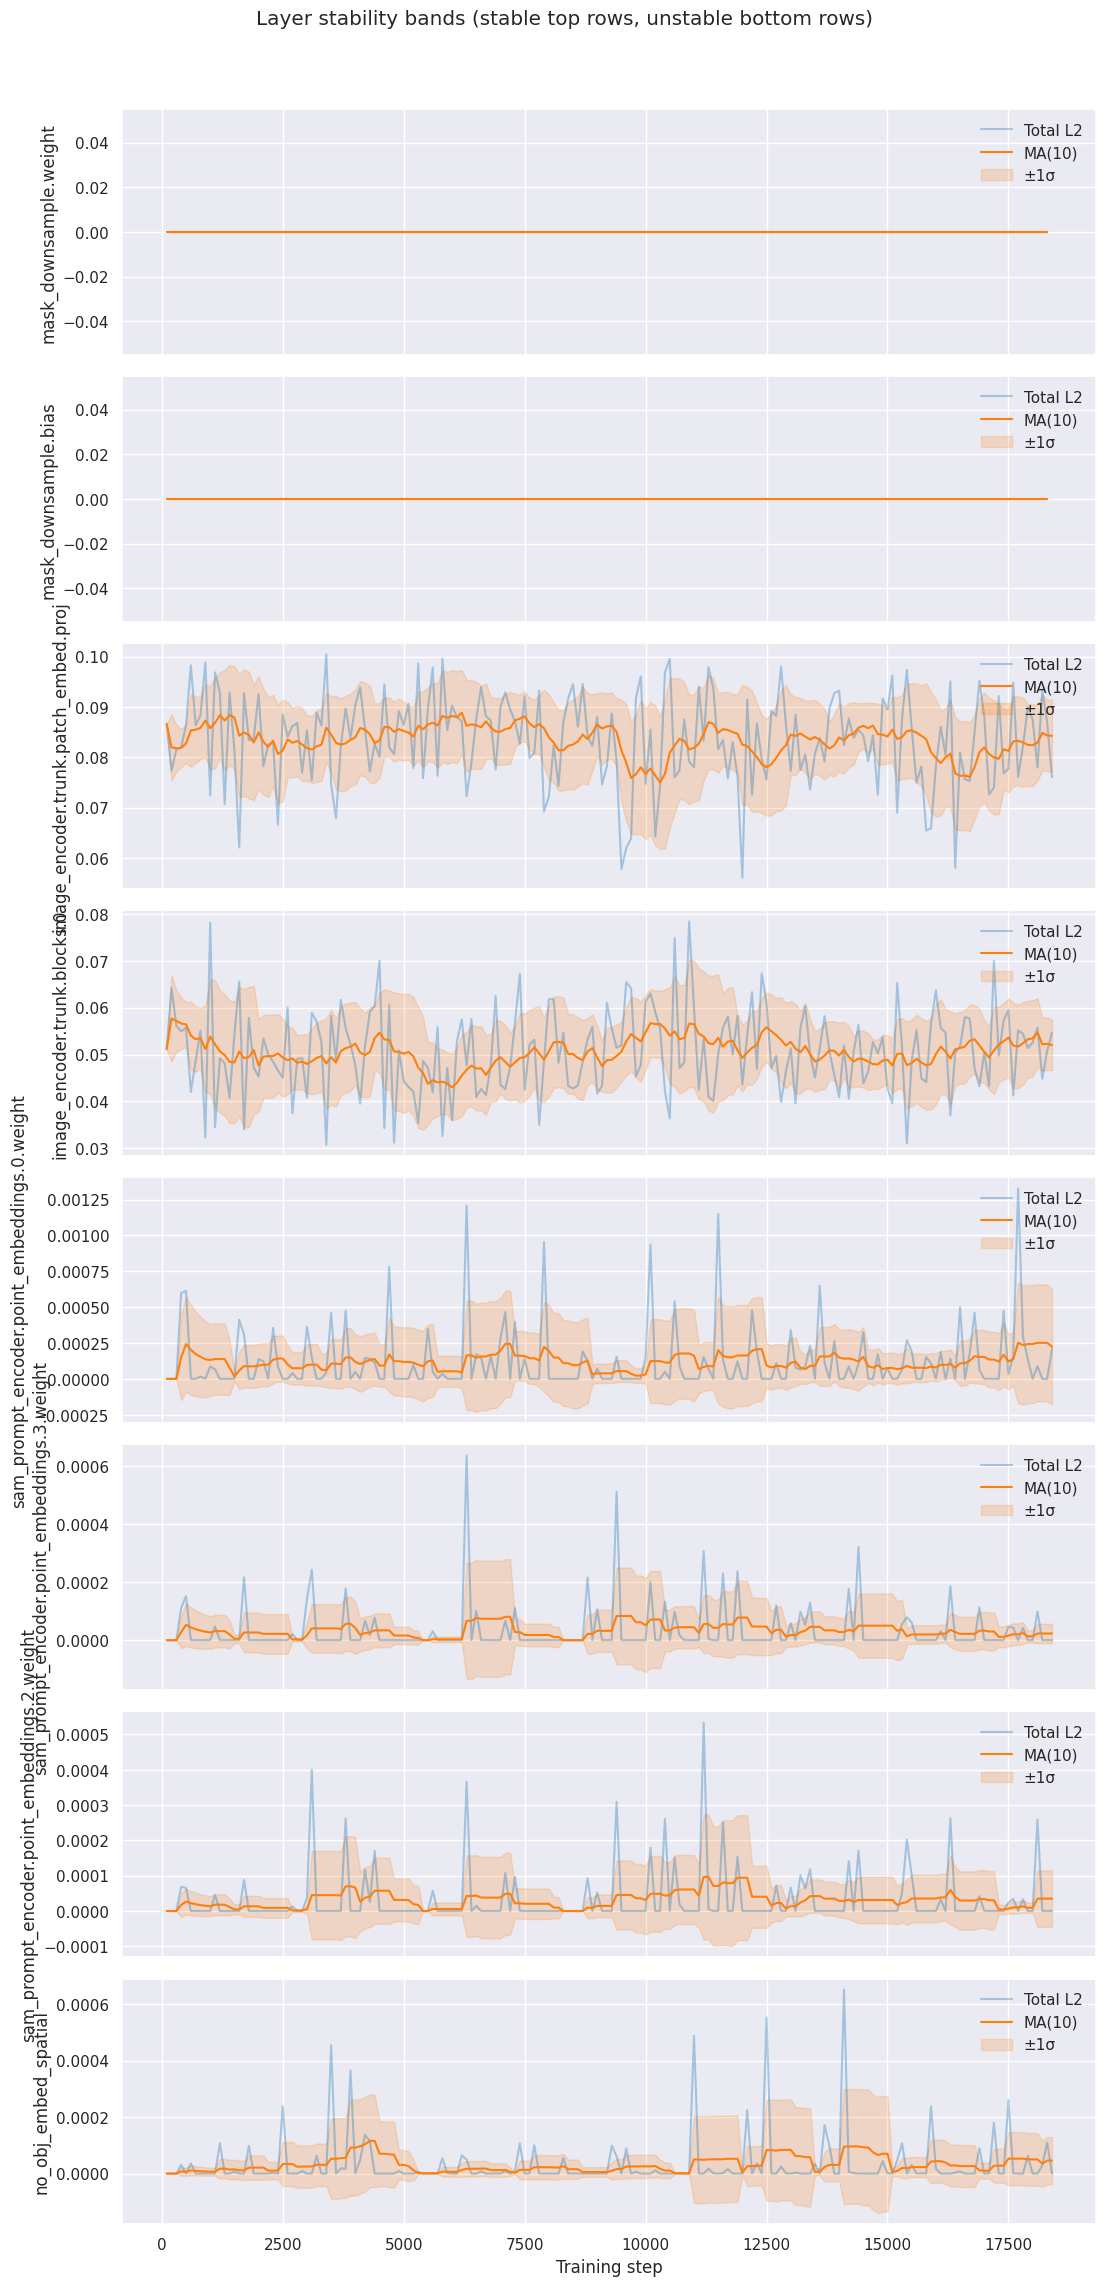

In [18]:

def compute_stability(df):
    ma_mean = df['ma_total_l2'].mean()
    std_mean = df['std_total_l2'].mean()
    denom = max(EPS, ma_mean)
    return std_mean / denom


stability_score = module_step.groupby('module_group').apply(compute_stability).sort_values()

stable_modules = stability_score.head(4).index
unstable_modules = stability_score.tail(4).index
selected_modules = list(stable_modules) + list(unstable_modules)

fig, axes = plt.subplots(len(selected_modules), 1, figsize=(11, 2.8 * len(selected_modules)), sharex=True)
if len(selected_modules) == 1:
    axes = [axes]

for ax, module in zip(axes, selected_modules):
    subset = module_step[module_step.module_group == module].sort_values('step')
    ax.plot(subset['step'], subset['total_l2'], color='#1f77b4', alpha=0.35, label='Total L2')
    ax.plot(subset['step'], subset['ma_total_l2'], color='#ff7f0e', label='MA(10)')
    upper = subset['ma_total_l2'] + subset['std_total_l2']
    lower = subset['ma_total_l2'] - subset['std_total_l2']
    ax.fill_between(subset['step'], lower, upper, color='#ff7f0e', alpha=0.2, label='±1σ')
    ax.set_ylabel(module)
    ax.legend(loc='upper right')

axes[-1].set_xlabel('Training step')
fig.suptitle('Layer stability bands (stable top rows, unstable bottom rows)', y=1.02)
plt.tight_layout()
plt.show()


## 12. Heavy-tailed layers and sparsity proxies

Layers with large `max/mean` ratios and high sparsity proxies suggest heavy-tailed or highly peaked gradients.

In [19]:

heavy_tail_summary = (
    module_step.groupby('module_group')[['max_to_mean_avg', 'sparsity_avg', 'grad_weight_ratio_mean']]
    .mean()
    .rename(columns={
        'max_to_mean_avg': 'avg_max_mean_ratio',
        'sparsity_avg': 'avg_sparsity_proxy',
        'grad_weight_ratio_mean': 'avg_grad_weight_ratio',
    })
    .sort_values('avg_max_mean_ratio', ascending=False)
)

heavy_tail_summary.head(20)


,avg_max_mean_ratio,avg_sparsity_proxy,avg_grad_weight_ratio
module_group,,,
sam_mask_decoder.output_upscaling.0.weight,"9,483,455.297582",0.996248,0.000587
sam_prompt_encoder.mask_downscaling.0.weight,"2,986,242.282909",0.866063,0.016957
sam_prompt_encoder.mask_downscaling.0.bias,"2,222,634.993925",0.781933,0.000286
memory_encoder.mask_downsampler.encoder.9,"1,512,586.173103",0.980618,0.000647
sam_mask_decoder.conv_s1.weight,"1,507,403.552024",0.985907,0.000045
sam_prompt_encoder.mask_downscaling.3.bias,"1,126,685.580834",0.921565,0.057274
sam_mask_decoder.transformer.final_attn_token_to_image.out_proj,"925,276.192886",0.958414,0.000151
sam_mask_decoder.transformer.layers.0,"597,590.454926",0.959415,0.000210
memory_attention.layers.3.linear1,"515,263.544311",0.992675,0.000065


## 13. Step × layer heatmap

Heatmap of grad/weight ratio reveals when specific layers become sensitive.

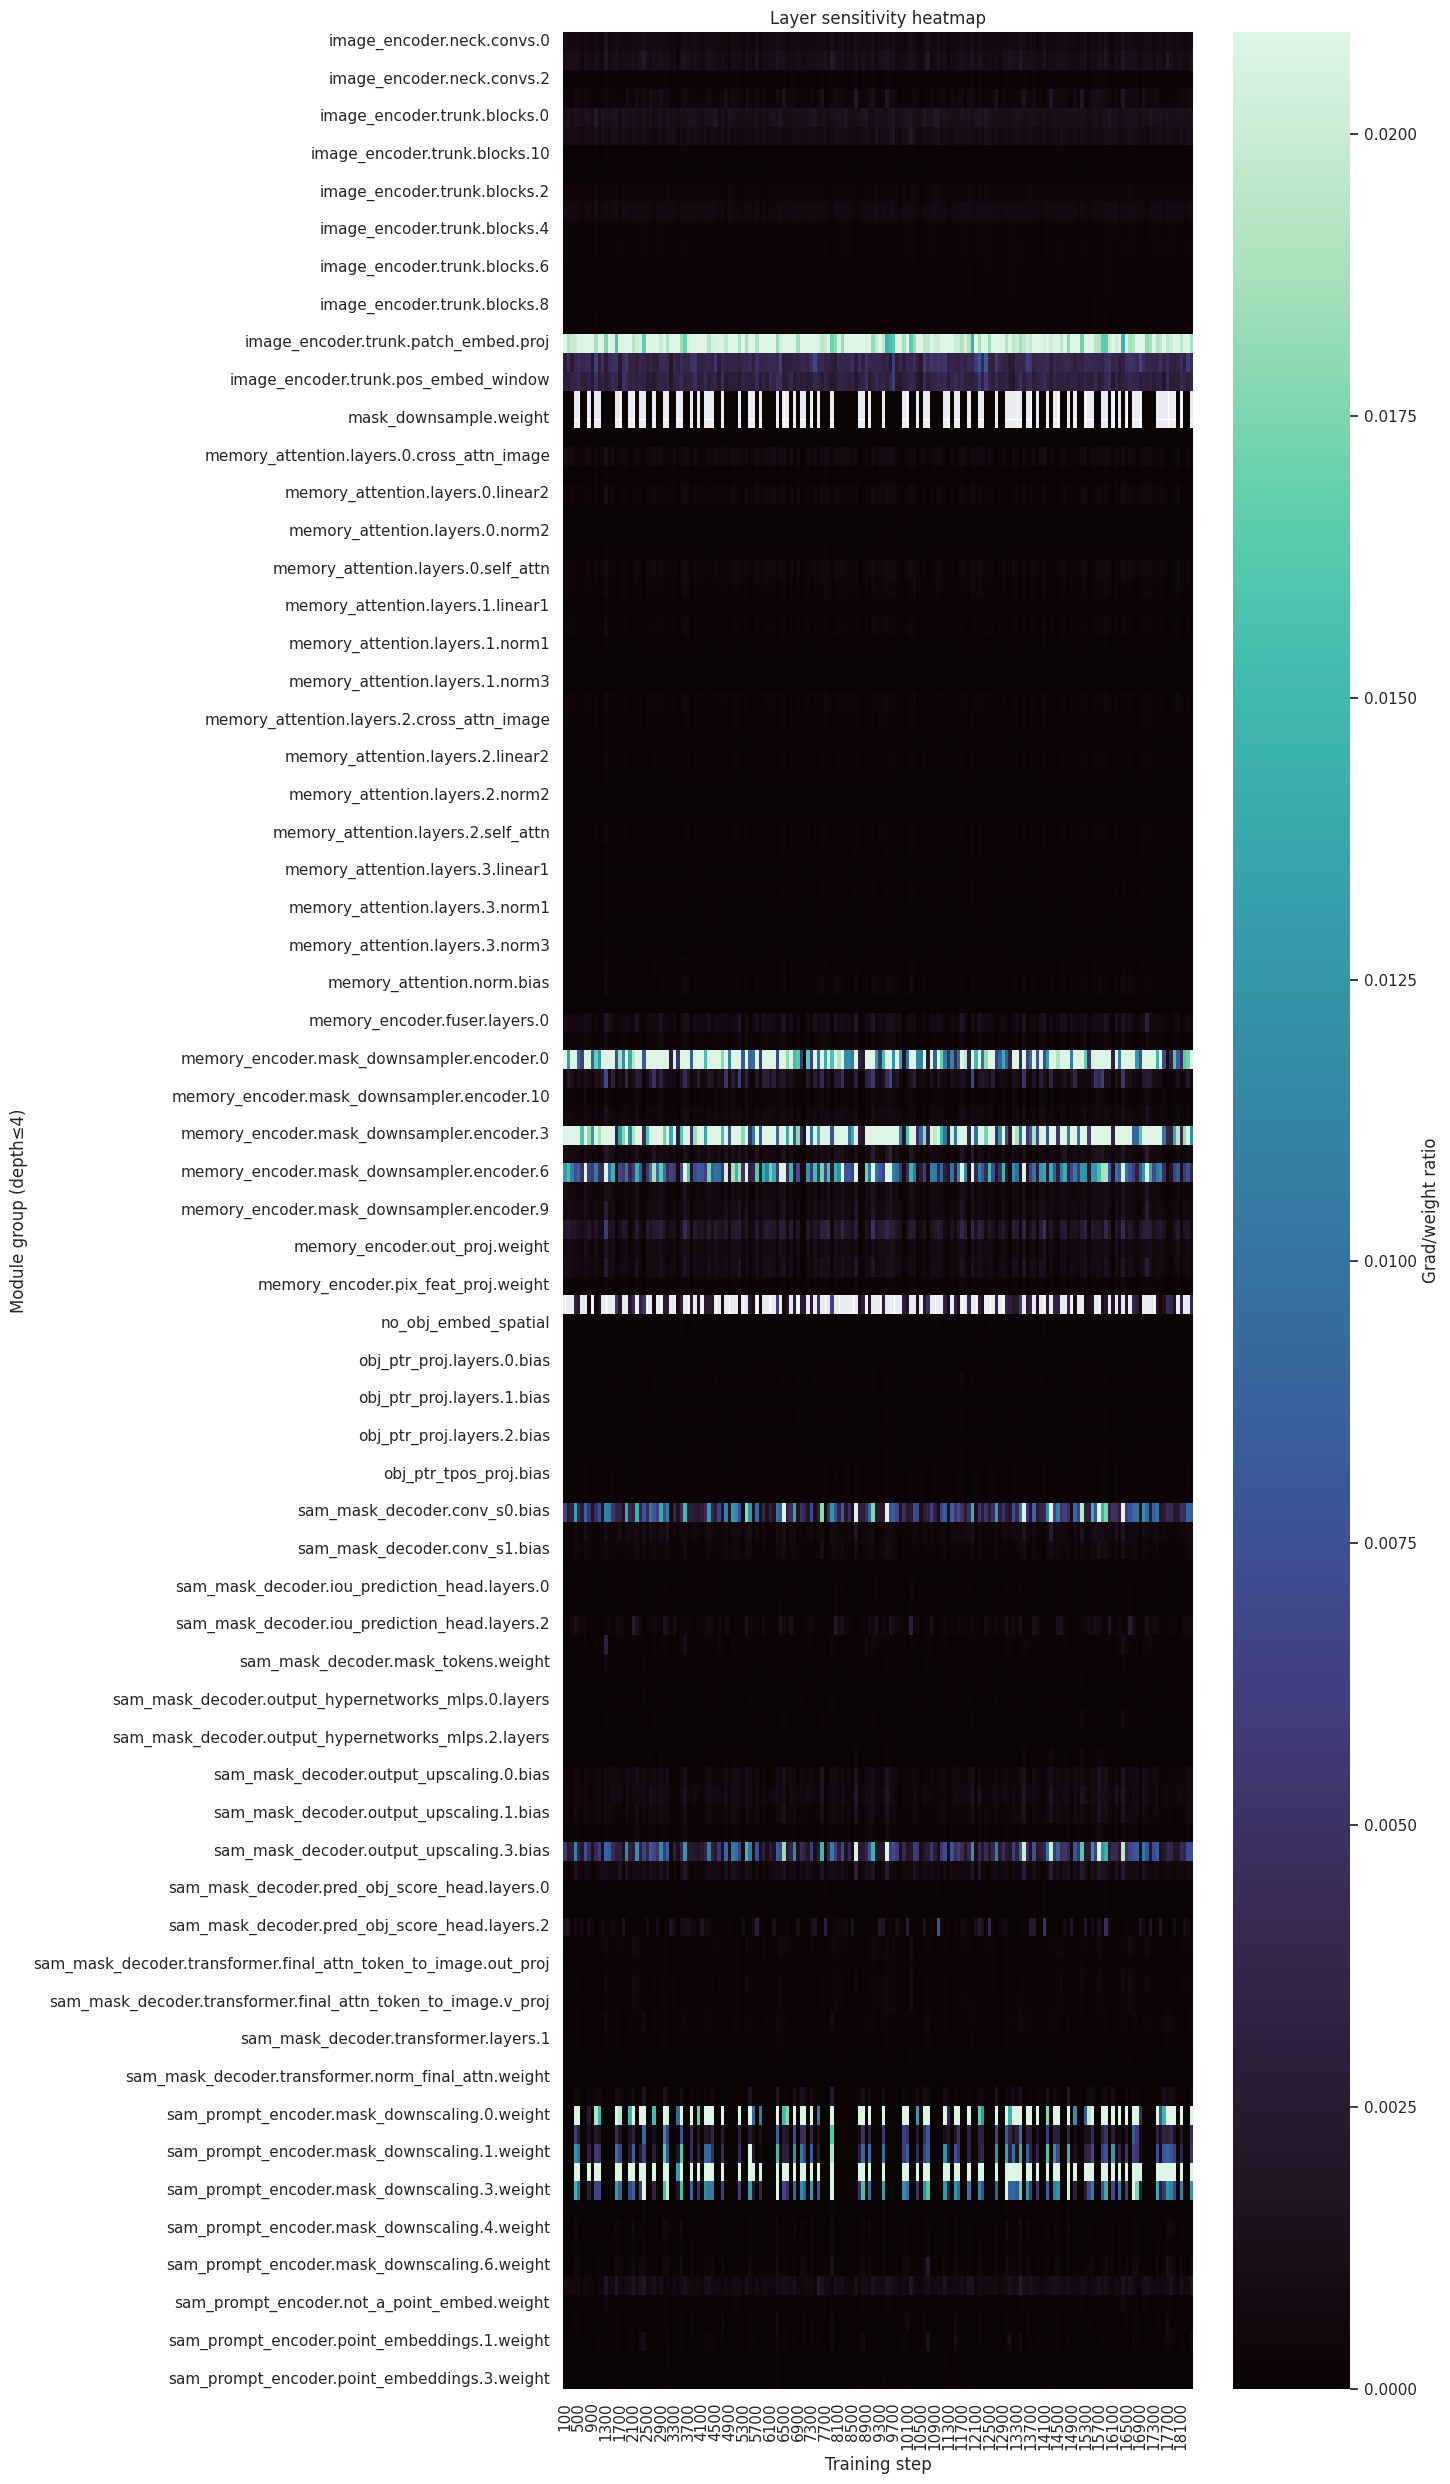

<Figure size 640x480 with 0 Axes>

In [20]:

heatmap_data = module_step.pivot(index='module_group', columns='step', values='grad_weight_ratio_mean')

plt.figure(figsize=(14, max(6, 0.2 * len(heatmap_data))))
sns.heatmap(heatmap_data, cmap='mako', cbar_kws={'label': 'Grad/weight ratio'}, robust=True)
plt.title('Layer sensitivity heatmap')
plt.xlabel('Training step')
plt.ylabel('Module group (depth≤4)')
plt.tight_layout()
plt.show()
plt.savefig(f'{model}_layer_sensitivity_heatmap.png')


## 14. Validation metrics (if available)

Attempts to align J&F / mIoU-style metrics with gradient flow. Update paths if your metrics live elsewhere.

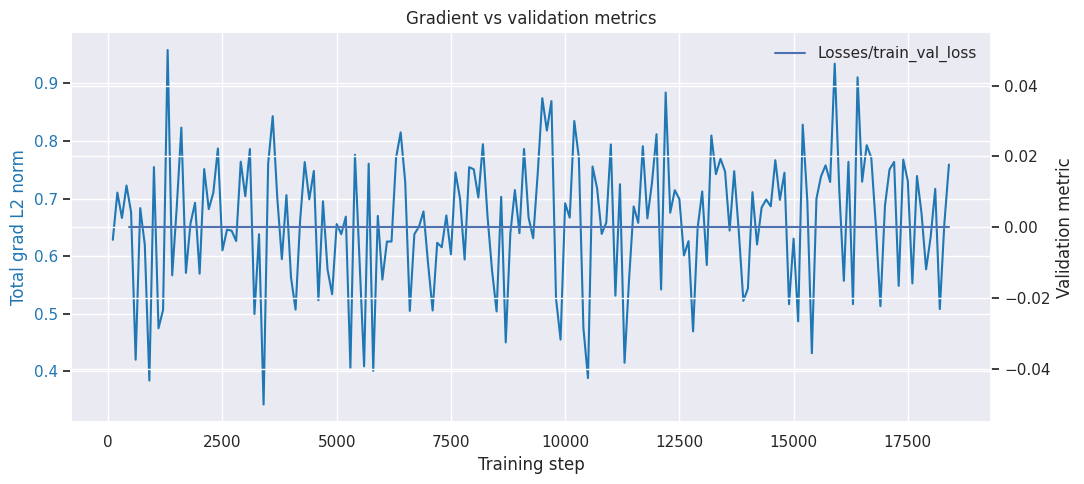

In [21]:

def load_jsonl(path: Path) -> pd.DataFrame:
    records = []
    if not path.exists():
        return pd.DataFrame()
    with path.open() as fp:
        for line in fp:
            line = line.strip()
            if not line:
                continue
            records.append(json.loads(line))
    return pd.DataFrame(records)


def find_validation_summary(experiment_dir: Path) -> Path | None:
    candidate = experiment_dir / 'eval_results' / 'summary_metrics.csv'
    if candidate.exists():
        return candidate
    global_candidates = sorted(Path('eval_results').glob('**/summary_metrics.csv'))
    return global_candidates[0] if global_candidates else None


train_stats_df = load_jsonl(TRAIN_STATS_PATH)
metric_cols = [c for c in train_stats_df.columns if any(key in c.lower() for key in ['val', 'j&f', 'jf', 'miou'])]

val_summary_path = find_validation_summary(EXPERIMENT_DIR)
if val_summary_path is not None:
    print(f'Validation summary found at: {val_summary_path}')
    summary_metrics_df = pd.read_csv(val_summary_path)
else:
    summary_metrics_df = pd.DataFrame()

if metric_cols:
    merged = train_stats_df[['Trainer/steps_train'] + metric_cols].dropna()
    gradient_trace = per_step.reset_index()[['step', 'total_l2_norm']]
    fig, ax1 = plt.subplots(figsize=(11, 5))
    ax1.plot(gradient_trace['step'], gradient_trace['total_l2_norm'], color='#1f77b4', label='Total grad L2')
    ax1.set_xlabel('Training step')
    ax1.set_ylabel('Total grad L2 norm', color='#1f77b4')
    ax1.tick_params(axis='y', labelcolor='#1f77b4')

    ax2 = ax1.twinx()
    for col in metric_cols:
        ax2.plot(merged['Trainer/steps_train'], merged[col], label=col)
    ax2.set_ylabel('Validation metric')
    ax2.legend(loc='upper right')
    plt.title('Gradient vs validation metrics')
    plt.tight_layout()
    plt.show()
else:
    print('No validation metrics detected in train_stats. Set VAL_METRICS_PATH below if you have offline evaluations.')

if not summary_metrics_df.empty:
    display(summary_metrics_df)


In [22]:

# Optional: manually point to additional validation logs (uncomment and edit)
# VAL_METRICS_PATH = Path('path/to/custom_metrics.csv')
# if VAL_METRICS_PATH.exists():
#     custom_metrics = pd.read_csv(VAL_METRICS_PATH)
#     display(custom_metrics.head())


## 15. Bit-width recommendation heuristics

Combines the diagnostics above to recommend a minimum per-layer precision (2–32 bits). Tune thresholds to match your quantisation tolerance.

In [23]:

module_summary = (
    module_step.groupby('module_group')
    .agg(
        avg_total_l2=('total_l2', 'mean'),
        avg_ratio=('grad_weight_ratio_mean', 'mean'),
        ratio_std=('grad_weight_ratio_mean', 'std'),
        avg_ma_total=('ma_total_l2', 'mean'),
        avg_std_total=('std_total_l2', 'mean'),
        avg_sparsity=('sparsity_avg', 'mean'),
        avg_heavy_tail=('max_to_mean_avg', 'mean'),
    )
    .fillna(0.0)
)

module_summary['stability_ratio'] = module_summary['avg_std_total'] / module_summary['avg_ma_total'].clip(lower=EPS)


def recommend_bits(row):
    ratio = row['avg_ratio']
    heavy = row['avg_heavy_tail']
    stability = row['stability_ratio']
    sparsity = row['avg_sparsity']

    notes = []
    bits = 8

    if np.isnan(ratio):
        return 8, 'Missing gradient stats'

    if ratio > 0.3 or heavy > 120:
        bits = 32
        notes.append('Extreme gradient-to-weight scaling')
        return bits, '; '.join(notes)

    if ratio > 0.15 or heavy > 60 or stability > 0.8:
        bits = max(bits, 16)
        notes.append('High gradient dynamics or heavy tails')

    if bits <= 8 and ratio < 0.03 and heavy < 20 and sparsity > 0.4:
        bits = min(bits, 4)
        notes.append('Low-energy + moderate sparsity')

    if bits <= 4 and ratio < 0.01 and heavy < 10 and sparsity > 0.6:
        bits = min(bits, 2)
        notes.append('Very stable & sparse layer')

    if not notes:
        notes.append('Default balance')

    return bits, '; '.join(notes)


module_summary[['recommended_bits', 'rationale']] = module_summary.apply(
    lambda row: pd.Series(recommend_bits(row)), axis=1
)
# display(module_summary.sort_values(['recommended_bits', 'avg_ratio'], ascending=[False, False]))
display(module_summary)
module_summary.to_csv(f'{model}/module_summary.csv', index=True)

,avg_total_l2,avg_ratio,ratio_std,avg_ma_total,avg_std_total,avg_sparsity,avg_heavy_tail,stability_ratio,recommended_bits,rationale
module_group,,,,,,,,,,
image_encoder.neck.convs.0,0.004196,0.000691,0.000209,0.004190,0.001221,0.949025,"15,753.591289",0.291435,32,Extreme gradient-to-weight scaling
image_encoder.neck.convs.1,0.009012,0.001058,0.000338,0.008985,0.002979,0.949265,"12,713.820415",0.331500,32,Extreme gradient-to-weight scaling
image_encoder.neck.convs.2,0.000629,0.000132,0.000072,0.000627,0.000318,0.945026,"13,790.654674",0.507552,32,Extreme gradient-to-weight scaling
image_encoder.neck.convs.3,0.001493,0.000476,0.000357,0.001489,0.001006,0.969825,"11,394.054533",0.675687,32,Extreme gradient-to-weight scaling
image_encoder.trunk.blocks.0,0.050612,0.001283,0.000212,0.050693,0.008691,0.956247,"36,046.681184",0.171449,32,Extreme gradient-to-weight scaling
...,...,...,...,...,...,...,...,...,...,...
sam_prompt_encoder.not_a_point_embed.weight,0.000193,0.000120,0.000074,0.000192,0.000108,0.902859,278.637409,0.562818,32,Extreme gradient-to-weight scaling
sam_prompt_encoder.point_embeddings.0.weight,0.000121,0.000074,0.000139,0.000120,0.000206,0.975132,127.551039,1.720051,32,Extreme gradient-to-weight scaling
sam_prompt_encoder.point_embeddings.1.weight,0.000189,0.000136,0.000229,0.000180,0.000273,0.973510,190.501489,1.511346,32,Extreme gradient-to-weight scaling


## 16. Next steps

- Filter `gradient_df` with custom string matches (e.g. `gradient_df[gradient_df.parameter.str.contains('decoder')]`) to inspect specific submodules.
- Combine with training metrics from `log.txt` or `train_stats.json` for correlation studies.
- Export aggregated statistics with `gradient_df.to_parquet(...)` if you want to perform offline comparisons across runs.
- Adjust the bit-width heuristic thresholds to align with your hardware quantisation constraints.